In [3]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd
import spotpy

sys.path.append("..")

from evaluation_metrics import nse_loss
from hydrological_models import HBV as hydrological_model
from modelcalibration import calibrate_basins
from modelcalibration_caravan import ModelCalibrationCaravan as model_calibration
from modelcalibration_caravan import check_basins_caravan as check_basins
from optimization_methods import dream as optimization_method
from spotpy.likelihoods import gaussianLikelihoodMeasErrorOut as obj_func

In [6]:
# Initialize information
path_entities = '/pfs/data6/home/ka/ka_iwu/ka_as2023/Hy2DL_Caravan/data/basin_id/testde_3.txt'
path_data = '/pfs/data6/home/ka/ka_iwu/ka_as2023/Hy2DL_Caravan/data/caravan'
input_variables = ['testde_2','evap', 'temperature_2m_mean']
target_variables = ["streamflow"]
training_period = ["2000-01-01", "2010-12-31"]
testing_period = ["2010-01-01", "2016-12-31"]
batch_size = 15
warmup_period = 365
random_seed = 700

# Save results
path_output = "../results/conceptual_models_CARAVAN_schwarzbach_lstm_R2/"

# use when one select the best parameters, depends on the loss function one wants.
maximize = True  # True for gaussian_likelihood, False of rmse

# set random seed
random.seed(random_seed)
np.random.seed(random_seed)

# Read information
basins_id = np.loadtxt(path_entities, dtype="str").tolist()
selected_basins_id = check_basins(
    path_data=path_data,
    basins_id=basins_id,
    target_variables=target_variables,
    training_period=training_period,
    testing_period=testing_period,
)

# Check if the path where one will store the results exists. In case it does not, it creates such path.
if not os.path.exists(path_output):
    # Create the folder
    os.makedirs(path_output)
    print(f"Folder '{path_output}' created successfully.")
else:
    print(f"Folder '{path_output}' already exists.")

Folder '../results/conceptual_models_CARAVAN_schwarzbach_lstm_R2/' already exists.


In [7]:
# Process the basins in batches (avoid memory issues)
batches = [selected_basins_id[i : i + batch_size] for i in range(0, len(selected_basins_id), batch_size)]
batches

[['testde_3',
  'testde_3',
  'testde_3',
  'testde_3',
  'testde_3',
  'testde_3',
  'testde_3',
  'testde_3']]

In [8]:
# Manual changes to ensure I only have one batch for my single basin
# Caution - this is a workaround I do for running for single basins - AMJ 09.10.2024
batches = [batches[0][:1]]
batches

[['testde_3']]

In [9]:
dfs = []
start_time = time.time()
for basin_batch in batches:
    training_object = {}
    testing_object = {}

    for basin in basin_batch:
        training_object[basin] = model_calibration(
            model=hydrological_model(),
            path_data=path_data,
            basin_id=basin,
            input_variables=input_variables,
            target_variables=target_variables,
            time_period=training_period,
            obj_func=obj_func,
            warmup_period=warmup_period,
        )

        testing_object[basin] = model_calibration(
            model=hydrological_model(),
            path_data=path_data,
            basin_id=basin,
            input_variables=input_variables,
            target_variables=target_variables,
            time_period=testing_period,
            obj_func=obj_func,
            warmup_period=warmup_period,
        )

    # Run the calibration of the different basins in parallel --------------------------------------------------
    optimizer = optimization_method(random_state=random_seed)
    calibrate_basins(
        training_object=training_object,
        optimization_method=optimizer,
        basins=basin_batch,
        path_output=path_output,
        random_seed=random_seed,
    )

    # Process and summarize the results -------------------------------------------------------------------------
    hyd_model = hydrological_model()
    optimizer = optimization_method()
    df_calibration = pd.DataFrame(
        index=range(len(basin_batch)),
        columns=["basin_id", "NSE_training"] + list(hyd_model.parameter_ranges) + ["NSE_testing"],
    )

    for i, basin in enumerate(basin_batch):
        # extract calibrated parameters
        file_name = path_output + hyd_model.name + "_" + optimizer.name + "_" + str(basin)
        results = spotpy.analyser.load_csv_results(file_name)
        calibrated_param = spotpy.analyser.get_best_parameterset(results, maximize=maximize)[0]

        # Training period ------------------------------------------
        q_sim = training_object[basin].simulation(calibrated_param)
        q_obs = training_object[basin].evaluation()

        # Convert to DataFrame and save - Single Basin
        df_train = pd.DataFrame({
            'q_sim': q_sim,
            'q_obs': q_obs
        })

        df_train.to_csv(f'{path_output}{hyd_model.name}_{optimizer.name}_train_{basin}.csv', index=False)

        # Calculate loss
        evaluation = q_obs[warmup_period:][training_object[basin].data_split[warmup_period:]]
        simulation = q_sim[warmup_period:][training_object[basin].data_split[warmup_period:]]
        mask_nans = ~np.isnan(evaluation)
        NSE_training = nse_loss(
            evaluation=evaluation[mask_nans].flatten(), simulation=simulation[mask_nans].flatten()
        )

        # Testing period ------------------------------------------
        q_sim = testing_object[basin].simulation(calibrated_param)
        q_obs = testing_object[basin].evaluation()

        # Convert to DataFrame and save - Single Basin
        df_test = pd.DataFrame({
            'q_sim': q_sim,
            'q_obs': q_obs
        })

        df_test.to_csv(f'{path_output}{hyd_model.name}_{optimizer.name}_test_{basin}.csv', index=False)
        
        # Calculate loss
        evaluation = q_obs[warmup_period:][testing_object[basin].data_split[warmup_period:]]
        simulation = q_sim[warmup_period:][testing_object[basin].data_split[warmup_period:]]

        # Mask NaNs in both evaluation and simulation
        mask_nans = ~np.isnan(evaluation) & ~np.isnan(simulation)

        # Apply the mask to both evaluation and simulation
        evaluation_masked = evaluation[mask_nans].flatten()
        simulation_masked = simulation[mask_nans].flatten()

        # Calculate the NSE loss
        NSE_testing = nse_loss(evaluation=evaluation_masked, simulation=simulation_masked)

        # Save the result of the basin
        df_calibration.loc[i] = [basin, NSE_training] + list(calibrated_param) + [NSE_testing]

    # Dataframe of the batch
    dfs.append(df_calibration)

 # Save the results
combined_df = pd.concat(dfs)
combined_df.to_csv(path_output + hyd_model.name + "_" + optimizer.name + "_summary.csv", index=False)
# Calculate and print the calibration time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total calibration time: {int(elapsed_time)} seconds")

Initializing the  DiffeRential Evolution Adaptive Metropolis (DREAM) algorithm  with  5000  repetitions
The objective function will be maximized
Starting the DREAM algotrithm with 5000 repetitions...
Initialize  7  chain(s)...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file '../results/conceptual_models_CARAVAN_schwarzbach_lstm_R2/HBV_dream_testde_3.csv' created.
Beginn of Random Walk


/home/ka/ka_iwu/ka_as2023/.local/lib/python3.11/site-packages/spotpy/algorithms/dream.py:238: RuntimeWarning: invalid value encountered in sqrt
  R_stat = np.sqrt(


67 of 5000, maximal objective function=-12213.2, time remaining: 00:02:26
Acceptance rates [%] =44.44 22.22 33.33 66.67 44.44 33.33 33.33
Convergence rates = 3.8578  3.0803  2.4253  3.7437 14.9196  4.715   2.9902  3.176   4.7649
  2.5403  5.1028  3.0542  2.5956  4.4984
134 of 5000, maximal objective function=-11906.8, time remaining: 00:02:26
Acceptance rates [%] =21.05 10.53 42.11 42.11 26.32 21.05 26.32
Convergence rates =8.4511 2.2631 2.5729 3.0372 2.0688 6.1904 3.7433 2.8116 4.1551 4.7056
 5.0146 7.479  3.037  2.6634
204 of 5000, maximal objective function=-11660.8, time remaining: 00:02:22
Acceptance rates [%] =13.79 10.34 27.59 31.03 20.69 20.69 20.69
Convergence rates =5.8382 2.9528 3.0379 4.6626 2.6522 5.5554 3.9815 2.4468 2.4657 3.2211
 3.3659 4.1345 4.517  4.5873
274 of 5000, maximal objective function=-11659.5, time remaining: 00:02:19
Acceptance rates [%] =10.26 15.38 23.08 25.64 23.08 15.38 17.95
Convergence rates = 4.1122  3.4015  3.8667  3.6229  3.5533  4.1023  3.1771  3

/home/ka/ka_iwu/ka_as2023/.local/lib/python3.11/site-packages/spotpy/algorithms/dream.py:111: RuntimeWarning: divide by zero encountered in scalar divide
  gamma = 2.38 / np.sqrt(2 * nchain_pairs * d_star)  # /self.gammalevel


551 of 5000, maximal objective function=-11659.5, time remaining: 00:02:10
Acceptance rates [%] =12.66  8.86 12.66 15.19 17.72  8.86 10.13
Convergence rates = 4.1709  5.5861  4.6857  5.2293  4.9777  6.3741  3.6542  8.6247  8.3018
 10.9303  2.9658  3.5219  4.9199  5.915 
621 of 5000, maximal objective function=-11659.5, time remaining: 00:02:08
Acceptance rates [%] =12.36  7.87 11.24 14.61 16.85  7.87  8.99
Convergence rates = 4.1946  7.047   4.4811  6.6425  6.7901  8.0568  3.991   6.6674 12.6851
 11.0156  3.4008  3.4332  5.2322  5.781 
691 of 5000, maximal objective function=-11659.5, time remaining: 00:02:06
Acceptance rates [%] =12.12  7.07 10.1  14.14 16.16  7.07  8.08
Convergence rates = 4.513   7.9354  5.2919  5.2351  6.9704  8.3877  4.1697  5.7596 10.5881
  8.683   3.6224  3.0833  4.6978  4.5655
761 of 5000, maximal objective function=-11583.6, time remaining: 00:02:04
Acceptance rates [%] =11.01  6.42 10.09 13.76 14.68  6.42  7.34
Convergence rates =4.62   6.0242 5.3175 3.6734 5

/pfs/data6/home/ka/ka_iwu/ka_as2023/Hy2DL_Caravan/Hy2DL/conceptual_models/hydrological_models.py:469: RuntimeWarning: invalid value encountered in divide
  uh = gamma_pdf / np.sum(gamma_pdf)


897 of 5000, maximal objective function=-11583.6, time remaining: 00:02:00
Acceptance rates [%] =10.08  5.43  8.53 12.4  12.4   5.43  6.2 
Convergence rates =3.653  4.4511 4.6701 3.0956 4.0954 4.2592 3.474  5.4098 6.1885 4.5095
 5.9224 3.2368 4.3474 4.0743
967 of 5000, maximal objective function=-11583.6, time remaining: 00:01:58
Acceptance rates [%] = 9.35  5.04  7.91 11.51 12.23  5.04  5.76
Convergence rates =3.4978 4.3162 4.6168 3.1354 4.0231 3.9975 3.4778 5.8854 5.7421 4.2156
 6.1932 3.5056 4.5803 4.3874
1037 of 5000, maximal objective function=-11583.6, time remaining: 00:01:56
Acceptance rates [%] = 8.72  4.7   7.38 10.74 11.41  4.7   5.37
Convergence rates =3.5362 4.4062 4.5097 3.2884 4.1928 3.9652 3.6374 6.7271 5.6725 4.0865
 6.4395 3.8062 5.0573 4.9274
1107 of 5000, maximal objective function=-11583.6, time remaining: 00:01:54
Acceptance rates [%] = 8.18  4.4   6.92 10.69 10.69  4.4   5.66
Convergence rates =3.7016 4.6278 4.3778 3.561  4.5711 4.0543 3.9563 6.3032 5.7845 4.0916

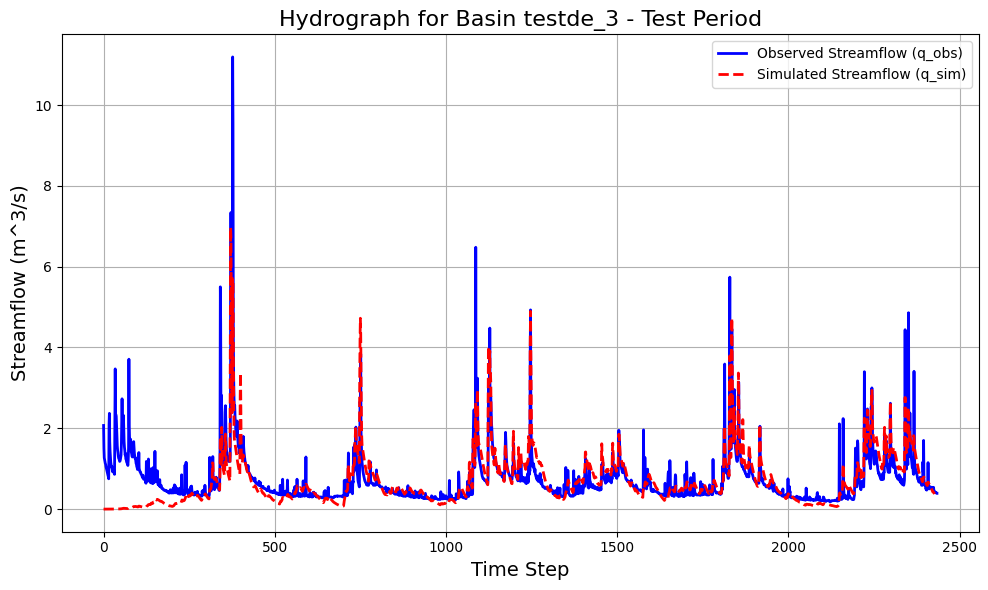

In [10]:
import matplotlib.pyplot as plt

# Read the df_test CSV file
df_test = pd.read_csv(f'{path_output}{hyd_model.name}_{optimizer.name}_test_{basin}.csv')

# Assuming the file has 'q_sim' and 'q_obs' columns
q_sim = df_test['q_sim']
q_obs = df_test['q_obs']

# Create a plot for the hydrograph
plt.figure(figsize=(10, 6))

# Plot observed streamflow
plt.plot(q_obs, label='Observed Streamflow (q_obs)', color='blue', linewidth=2)

# Plot simulated streamflow
plt.plot(q_sim, label='Simulated Streamflow (q_sim)', color='red', linestyle='--', linewidth=2)

# Adding labels and title
plt.title(f"Hydrograph for Basin {basin} - Test Period", fontsize=16)
plt.xlabel("Time Step", fontsize=14)  # Assuming each row is a time step
plt.ylabel("Streamflow (m^3/s)", fontsize=14)
plt.grid(True)

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

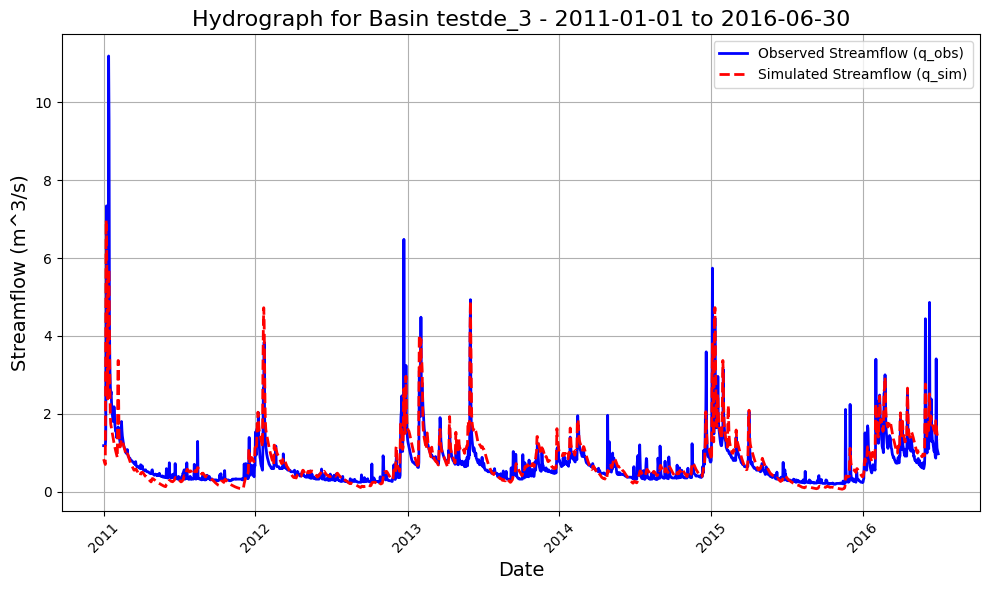

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the testing period
start_date = "2010-01-01"
end_date = "2016-12-31"


# Read the df_test CSV file
df_test = pd.read_csv(f'{path_output}{hyd_model.name}_{optimizer.name}_test_{basin}.csv')

# Assuming the file has 'q_sim' and 'q_obs' columns
q_sim = df_test['q_sim']
q_obs = df_test['q_obs']

# Create a date range based on the testing period (adjust the frequency if needed)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Ensure the date range matches the length of your data
if len(date_range) != len(q_sim):
    raise ValueError(f"The date range length {len(date_range)} does not match the data length {len(q_sim)}")

# Define the custom time window
custom_start_date = "2011-01-01"
custom_end_date = "2016-06-30"

# Filter the date range and data based on the custom time window
mask = (date_range >= custom_start_date) & (date_range <= custom_end_date)
custom_dates = date_range[mask]
custom_q_sim = q_sim[mask]
custom_q_obs = q_obs[mask]

# Create a plot for the custom hydrograph
plt.figure(figsize=(10, 6))

# Plot observed streamflow
plt.plot(custom_dates, custom_q_obs, label='Observed Streamflow (q_obs)', color='blue', linewidth=2)

# Plot simulated streamflow
plt.plot(custom_dates, custom_q_sim, label='Simulated Streamflow (q_sim)', color='red', linestyle='--', linewidth=2)

# Adding labels and title
plt.title(f"Hydrograph for Basin {basin} - {custom_start_date} to {custom_end_date}", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Streamflow (m^3/s)", fontsize=14)
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

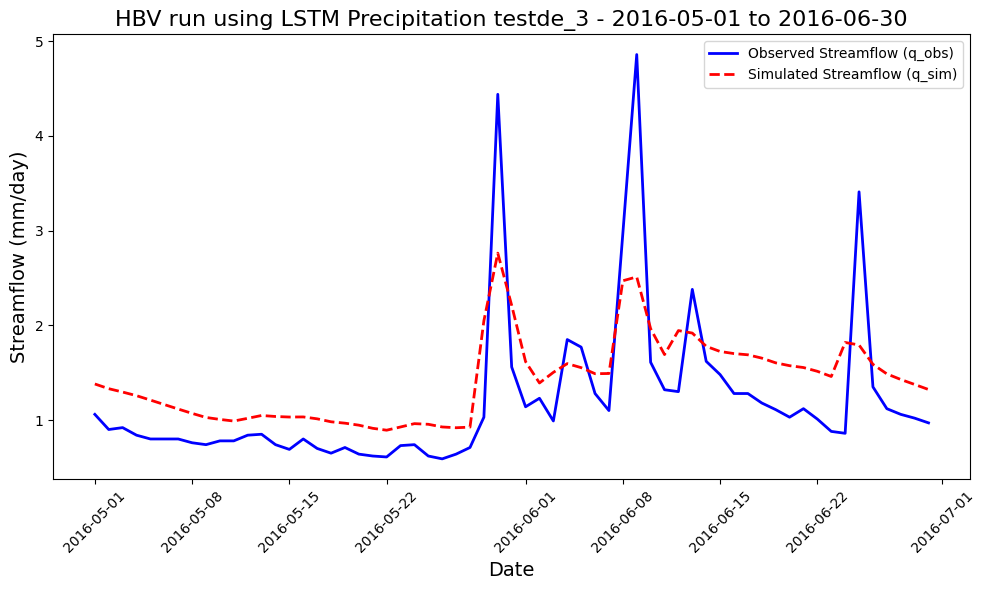

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the testing period
start_date = "2010-01-01"
end_date = "2016-12-31"

# Read the df_test CSV file
df_test = pd.read_csv(f'{path_output}{hyd_model.name}_{optimizer.name}_test_{basin}.csv')

# Assuming the file has 'q_sim' and 'q_obs' columns
q_sim = df_test['q_sim']
q_obs = df_test['q_obs']

# Create a date range based on the testing period (adjust the frequency if needed)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Ensure the date range matches the length of your data
if len(date_range) != len(q_sim):
    raise ValueError(f"The date range length {len(date_range)} does not match the data length {len(q_sim)}")

# Define the custom time window
custom_start_date = "2016-05-01"
custom_end_date = "2016-06-30"

# Filter the date range and data based on the custom time window
mask = (date_range >= custom_start_date) & (date_range <= custom_end_date)
custom_dates = date_range[mask]
custom_q_sim = q_sim[mask]
custom_q_obs = q_obs[mask]

# Create a plot for the custom hydrograph
plt.figure(figsize=(10, 6))

# Plot observed streamflow
plt.plot(custom_dates, custom_q_obs, label='Observed Streamflow (q_obs)', color='blue', linewidth=2)

# Plot simulated streamflow
plt.plot(custom_dates, custom_q_sim, label='Simulated Streamflow (q_sim)', color='red', linestyle='--', linewidth=2)

# Adding labels and title
plt.title(f"HBV run using LSTM Precipitation {basin} - {custom_start_date} to {custom_end_date}", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Streamflow (mm/day)", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
